# Dynamic Programming and Reinforcement Learning

In [1]:
import random as rd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import pandas as pd

## Tree Class

Tree class modelise the three and the MDP

In [2]:
class Tree:
    
    def __init__(self,initSize,H,discount=1/1.05,valueUnitOfWood=10,costOfPlanting=-5
                 ,costOfMaintenance=-10,probaOfSick=1/16,probaOfGrowTwice=1/16,probaOfNotGrow=2/16):
        self.size=initSize
        self.initSize=initSize
        self.Hmax=H
        self.discount=discount
        self.valueUnitOfWood=valueUnitOfWood
        self.costOfPlanting=costOfPlanting
        self.costOfMaintenance=costOfMaintenance
        self.probaOfSick=probaOfSick
        self.probaOfGrowTwice=probaOfGrowTwice
        self.probaOfNotGrow=probaOfNotGrow
        self.probaOfGrowOne=1-(self.probaOfNotGrow+probaOfGrowTwice+probaOfSick)
    

    def get_all_rewards(self):
        R={}
        R[(-1,0)]=self.costOfMaintenance
        R[(-1,1)]=self.costOfPlanting
        for i in range(1,self.Hmax+1):
            R[(i,0)]=self.costOfMaintenance
            R[(i,1)]=i*self.valueUnitOfWood+self.costOfPlanting 
        return R

        
 
    def tree_sim(self,x,a,verbose=0): # One step
        
        reward=0
        
        if a==1 or x==-1 : # Cutting tree or sick tree
            # the reward is height* the value of one unit of wood - maintenance cost 
            # if the tree is sick it's only maintenance cost
            if x==-1:
                reward=self.costOfPlanting
            else:
                reward=x*self.valueUnitOfWood+self.costOfPlanting 
            x=1
        
        else : # Don't cut the tree
            choose=rd.random()

            # Getting sick with prob 1/16
            
            if choose<=(self.probaOfSick) :
                if verbose==1 :
                    print('The tree is falling sick')
                reward=self.costOfMaintenance
                x=-1
              
            #  Grow of 2 units with prob 1/16
            
            if choose>self.probaOfSick and choose<=(self.probaOfSick+self.probaOfGrowTwice) :
                if verbose==1 :
                    print('The tree grows of two units')
                
                if x<self.Hmax:
                    x=x+2
                
                reward=self.costOfMaintenance
             
            # Don't grow with prob 1/8
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice) and choose<=(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow):
                if verbose==1 :
                    print('The tree does not grow')
                    
                reward=self.costOfMaintenance

            # Grow of 1 unit with prob 3/4
            
            if choose>(self.probaOfSick+self.probaOfGrowTwice+self.probaOfNotGrow) and choose<=1 :
                if verbose==1 :
                    print('The tree grows of one unit')
                
                if x<self.Hmax:
                    x=x+1
                
                reward=self.costOfMaintenance


        return reward,x
        
    def tree_MDP(self,actions,verbose=0): # The whole MDP starting from 1
        
        rewards=[]
        treeSizes=[]
        i=1
        
        if len(actions)==1:
            a=actions[0]
            sim=self.tree_sim(self.size,a,verbose)
            treeSizes=sim[1]
            rewards=sim[0]
            self.size=treeSizes
            
        if len(actions)>1:
            for a in actions:
                sim=self.tree_sim(self.size,a,verbose)
                x=sim[1]
                r=sim[0]*self.discount**(i) # Discounted reward
                self.size=x
                treeSizes.append(x)
                rewards.append(r)
                i=i+1
            
        return rewards,treeSizes
    

        
    def plot_MDP(self,rewards,treeSizes,cumul=True): # Plot cumulative sum of rewards and tree height
            

        plt.figure(figsize=(20,10))
        limit=np.zeros(len(treeSizes))-1
        plt.subplot(1,2,1)
        plt.plot(treeSizes,color='darkgreen',lw=3)
        plt.plot(limit,color='red',lw=1,alpha=0.8,linestyle='--')
        plt.xlim([-1,len(rewards)])
        #plt.ylim([0,max(treeSizes)+1])
        plt.title('Simulation of a growing tree', fontsize=15)
        plt.ylabel('Tree\'s Height', fontsize=10)
        plt.xlabel('time', fontsize=10)
        #plt.yticks(range(max(treeSizes)))
       
        plt.subplot(1,2,2)
        plt.plot(rewards,'r-')
        if cumul==True:
            plt.plot(np.cumsum(rewards),'b--',lw=2)
        plt.title('Rewards', fontsize=15)
        plt.ylabel('Value of rewards', fontsize=10)
        plt.xlabel('time', fontsize=10)
        #plt.yticks(range(min(np.cumsum(rewards)),max(rewards),3))
        plt.legend(['Reward at each time','Cumulative sum of rewards'])

        plt.show()
        
   
    

## Compute Matrix

ComputeMatrix class create the following matrix and allow operation on it :

$$P1=
\begin{pmatrix}
   0 & 0 & \ldots & \ldots & \ldots & \ldots  & 0 \\
   1/16 & 2/16 & 12/16 & 1/16 & 0 & \ldots  & 0 \\
   1/16 & 0 & 2/16 & 12/16 & \ddots & \ldots & 0 \\
   1/16 & 0 & 0 & 2/16 & \ddots & \ddots  & 0 \\
   \vdots & \vdots & \vdots & 0 & \ddots & \ddots & 1/16\\
   \vdots & \vdots & \vdots & \vdots & \ddots & \ddots & 12/16\\
   1/16 & 0 & 0 & 0 & 0 & 0 & 2/16\\
\end{pmatrix}$$



$$P2=
\begin{pmatrix}
   0 &1 & 0 & \ldots & 0  \\
   0 & 1 & 0 & \ldots & 0 \\
   \vdots & \vdots & \vdots & \ldots & \vdots \\
   0& 1 & 0 &\ldots & 0   
\end{pmatrix}$$

In [3]:
class ComputeMatrix:
 
    def tridiag(self,a, b, c, k1=-1, k2=0, k3=1):
        return np.diag(a, k1) + np.diag(b, k2) + np.diag(c, k3)
    
    def computePQ(self,H):
        a=np.zeros(H)+2/16
        b=np.zeros(H-1)+12/16
        c=np.zeros(H-2)+1/16
        e=np.zeros(H)+1/16
        e[0]=3/16
        P=self.tridiag(a, b, c,k1=0,k2=1,k3=2)
        P[:,0]=e
        Q=np.zeros((H,H))
        Q[:,0]=np.ones(H)
        return P,Q
        
    def inv(self,P,discount):
        I=np.eye(len(P))
        M1=(I-discount*P)
        Pinv=np.linalg.inv(M1)
        return Pinv           

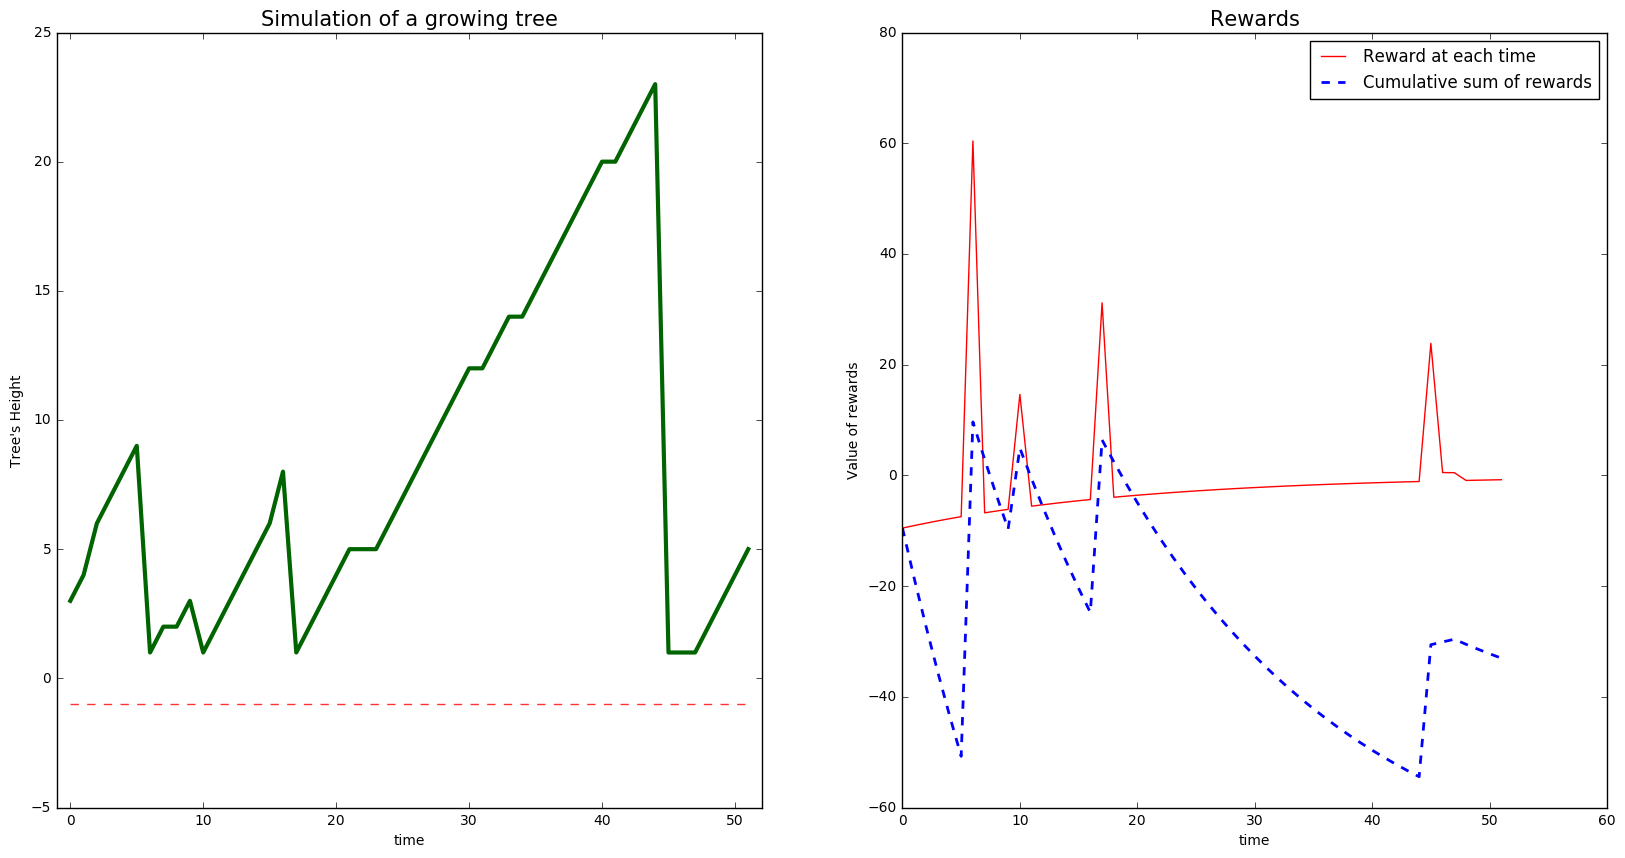

In [4]:
t=Tree(initSize=1,H=100)
actions=[0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0]
rewards,treeSizes=t.tree_MDP(actions,verbose=0)
t.plot_MDP(rewards,treeSizes)

## Les Agents

Agents follow a policy and compute it's value.
The value is computed using Monte-Carlo methods, Bellman iterative computation, and Bellman direct computation.

In [32]:
class Agent(ComputeMatrix) :
    
    def __init__(self):
        ComputeMatrix.__init__(self)
    
    def policy(self,x): # Each agent implement is own policy
        raise NotImplementedError("Dumb ass ! Please implement this method") 
        
    def simul_policy(self,nIter,tree,nbRuns=1): # Mean rewards and three height for a given policy on multiple runs
        rewards=np.zeros((nIter,nbRuns))
        treeSizes=np.zeros((nIter,nbRuns))

        for run in range(nbRuns):
            t=Tree(initSize=tree.initSize
            ,costOfMaintenance=tree.costOfMaintenance
            ,costOfPlanting=tree.costOfPlanting
            ,H=tree.Hmax
            ,valueUnitOfWood=tree.valueUnitOfWood)
            actions=[]
            for i in range(nIter):
                
                a=self.policy(t.size)            
                res=t.tree_MDP([self.policy(i)])
                rewards[i,run]=res[0]*tree.discount**(i)
                treeSizes[i,run]=res[1]
                actions.append(a)   
                    
        if nbRuns==1:
            return rewards,treeSizes,actions
        else:
            return np.mean(rewards,axis=1),np.mean(treeSizes,axis=1)
        
    def plot_policy(self,nIter,nbRuns,tree): # Plot rewards and three heigth evolution
        rewards,treeSizes=self.simul_policy(nIter=nIter,nbRuns=nbRuns,tree=tree)
        tree.plot_MDP(rewards,treeSizes)
    
    # Compute P and R of the Bellman equation for a given policy
    def find_P_R(self,tree):
        rewards_dic=tree.get_all_rewards()
        P1,P2=self.computePQ(tree.Hmax+1)
        P=np.zeros((tree.Hmax+1,tree.Hmax+1))
        R=[]
        
        
        for i in [-1]+list(range(1,tree.Hmax+1)): # Return all state
            R.append(rewards_dic[(i,self.policy(i))])
            
            # Dead tree : this case is handled in the first row
            if i==-1:
                P[0,:]=P2[0,:]
            else:
                if self.policy(i)==0:
                    P[i,:]=P1[i,:]
                if self.policy(i)==1:
                    P[i,:]=P2[i,:]
        return P,R
        
    def bellman_op(self,tree,v): # Bellman operator
        P,R=self.find_P_R(tree)
        
        return R+tree.discount*np.dot(P,v)
    
    def ev_policy_iterative_computation(self,tree,nIter): # Bellman iterative computation
        V=np.zeros(tree.Hmax+1)+10
        
        for i in range(nIter):
            V=self.bellman_op(tree,V)
        
        return V
        
    def ev_policy_direct_computation(self,tree): # Bellman direct computation
        
        P,R=self.find_P_R(tree)
        
        Pinv=self.inv(P,discount=tree.discount)
        V=np.dot(Pinv,R)
        
        return V
    
    def ev_policy_motecarlo(self,tree,nIter,nbRuns):  # Every visit Monte-Carlo simulation
        rewards=np.zeros((nIter,nbRuns))
        treeSizes=np.zeros((nIter,nbRuns))
        V=[]
        # For each state
        for x in [-1]+list(range(1,tree.Hmax+1)):
            
            rewards_trajectory=[]
            # Simulate trajectories starting from a specific state
            for run in range(nbRuns):
                
                # Compute a tree with height x
                t=Tree(initSize=x
                ,costOfMaintenance=tree.costOfMaintenance
                ,costOfPlanting=tree.costOfPlanting
                ,H=tree.Hmax
                ,valueUnitOfWood=tree.valueUnitOfWood)
            
                # Explore following state
                rewards=[]
                for i in range(nIter):

                    a=self.policy(t.size)            
                    res=t.tree_MDP([self.policy(i)])
                    rewards.append(res[0]*tree.discount**(i))
                    #rewards.append(res[0])

                    
                rewards_trajectory.append(np.sum(rewards))
                
            V.append(np.mean(rewards_trajectory))
    
        return V
        


### Arbitrary Agent

In [33]:
class ArbitraryAgent(Agent): # Inherit from Agent class
    
    def __init__(self,cut=10):
        Agent.__init__(self)
        self.cut=cut
     
    # Simple policy : cut only if the three grow above a given limit
    def policy(self,x):
        if x>=self.cut:
            return 1
        else:
            return 0
                

### Illustration

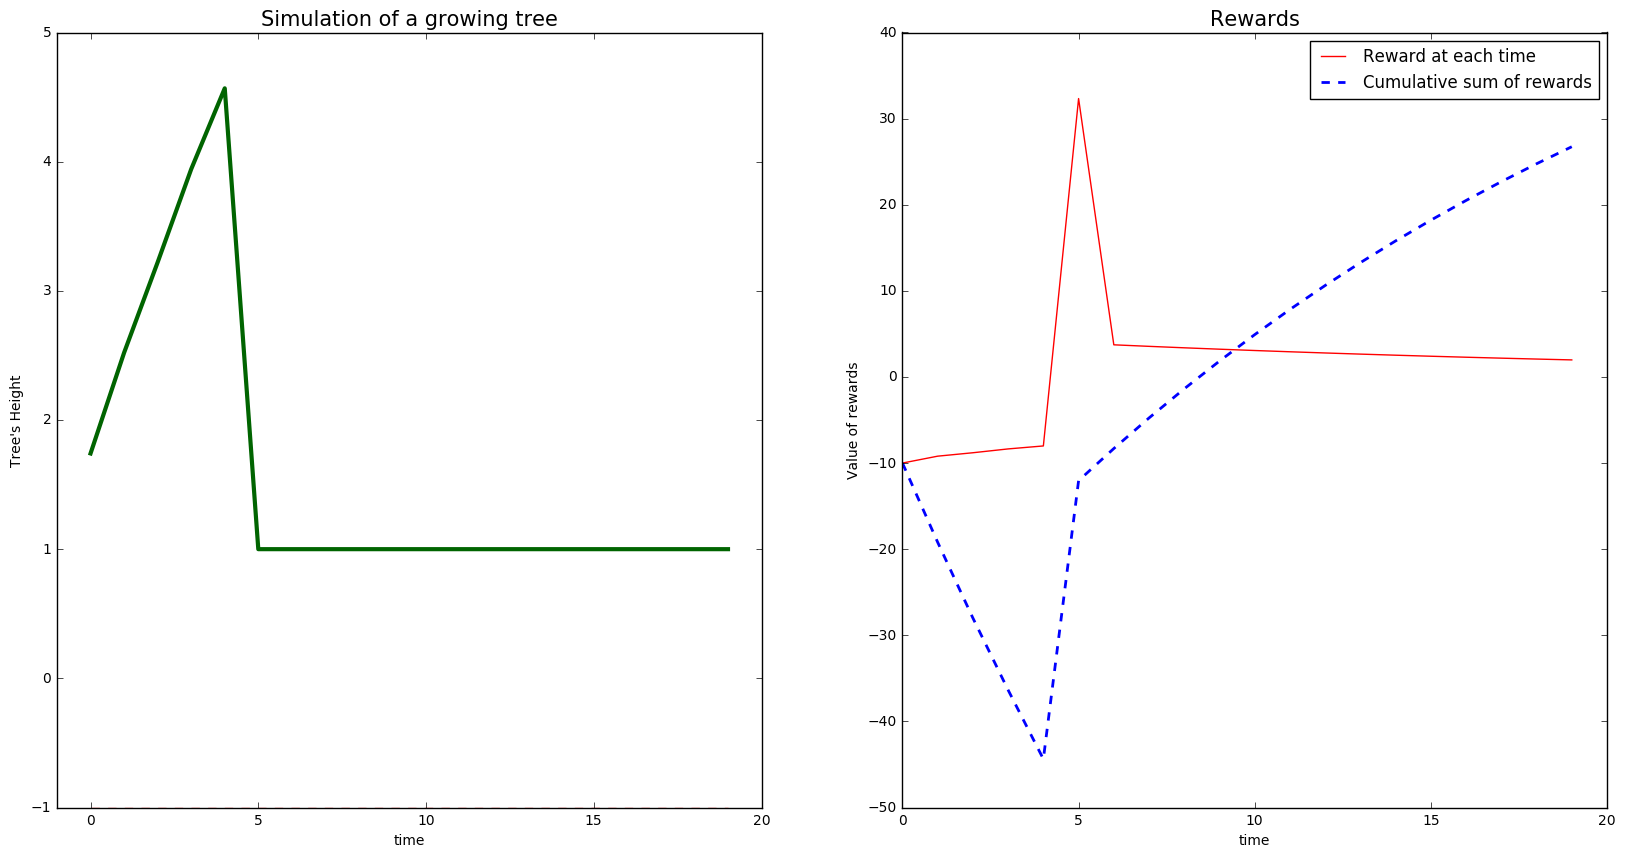

In [34]:
t=Tree(initSize=1,H=10)
arbA=ArbitraryAgent(cut=5)
arbA.plot_policy(nIter=20,nbRuns=1000,tree=t)

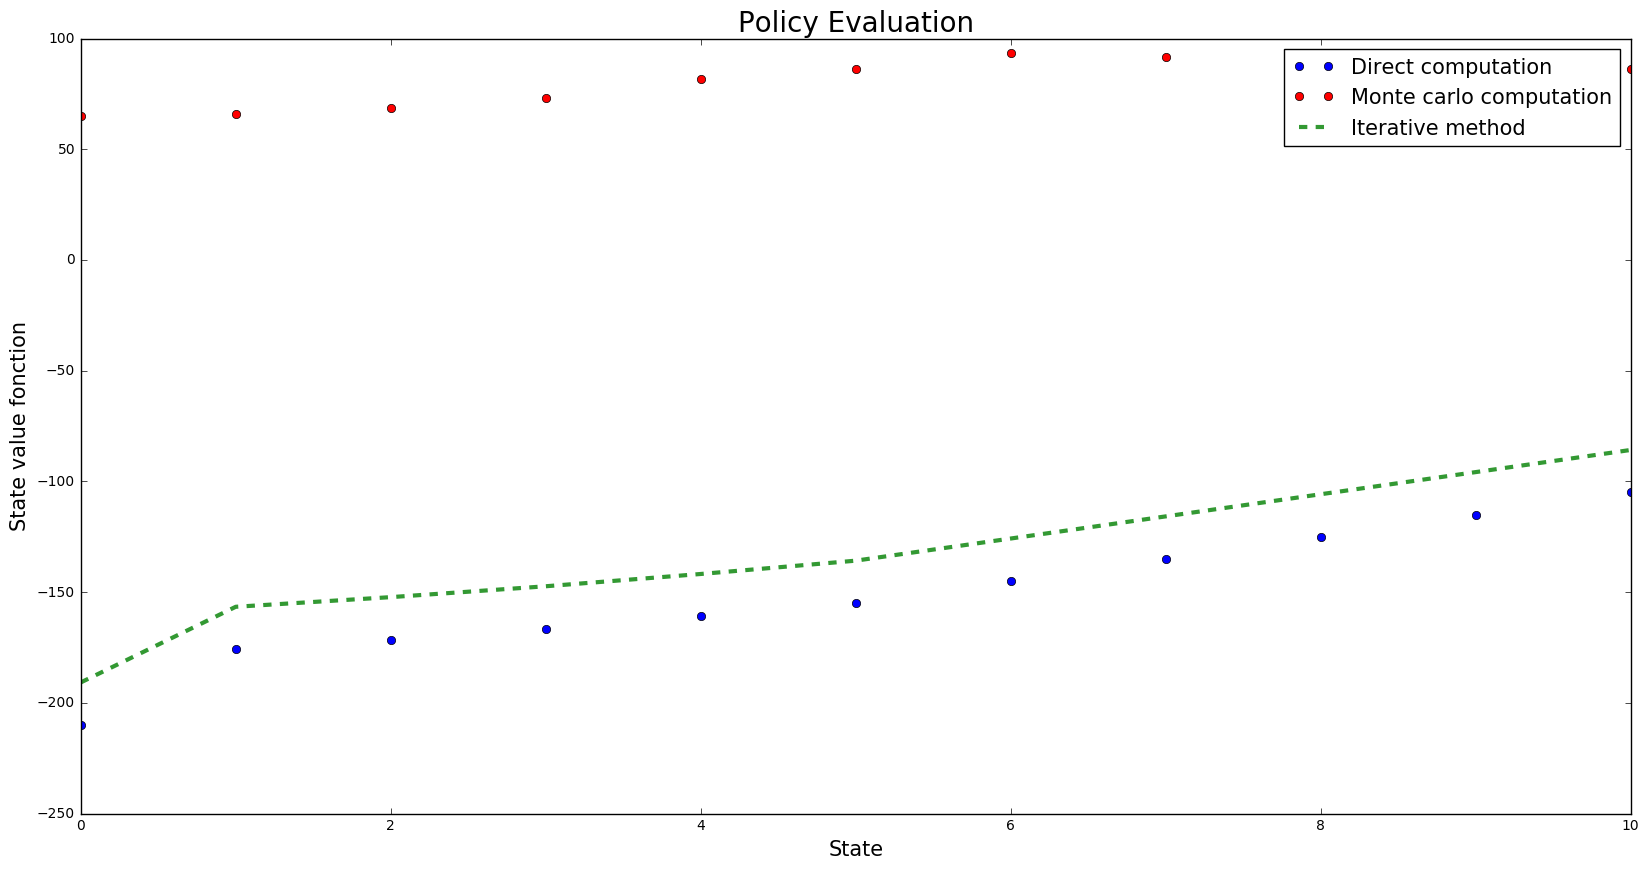

In [41]:
Vdirect=arbA.ev_policy_direct_computation(t)
Vmonte=arbA.ev_policy_motecarlo(t,100,100)
Vinte=arbA.ev_policy_iterative_computation(t,50)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.plot(Vmonte,'ro')
plt.plot(Vinte,'g--',lw=3,alpha=0.8)
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation','Monte carlo computation','Iterative method'],fontsize=15)
plt.show()

### Interative Bellman convergence

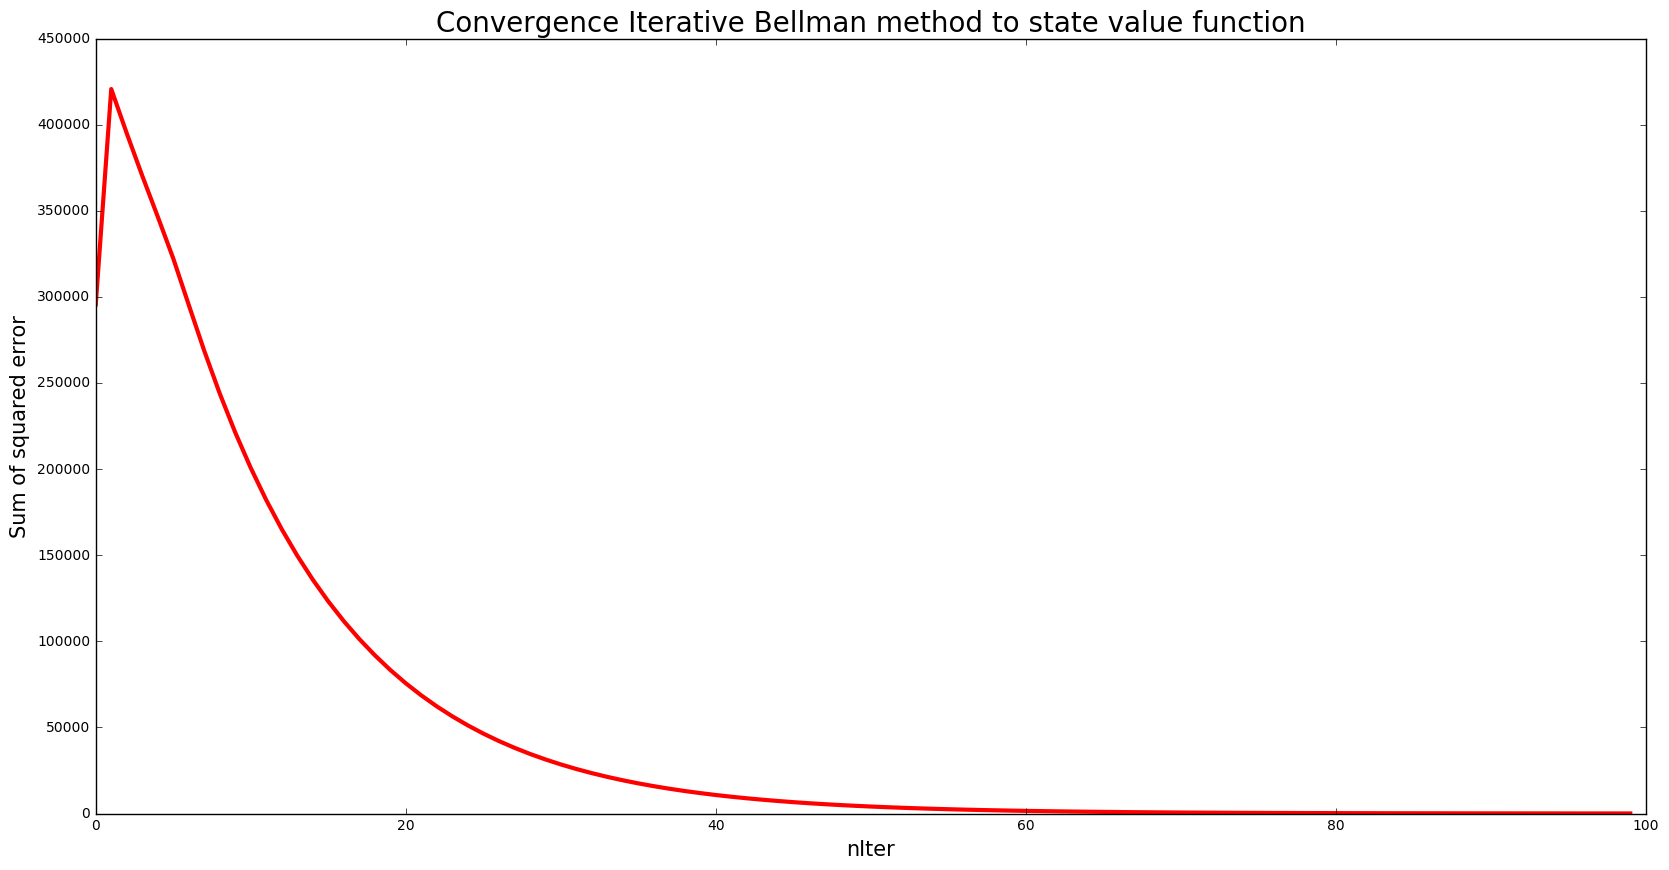

In [63]:
Vdirect=arbA.ev_policy_direct_computation(t)
error=[]
for i in range(100):
    Vinte=arbA.ev_policy_iterative_computation(t,i)
    error.append(np.sum(abs(np.array(Vinte)-np.array(Vdirect))**2))
    
plt.figure(figsize=(20,10))
plt.plot(error,'r-',lw=3)
plt.title('Convergence Iterative Bellman method to state value function',fontsize=20)
plt.xlabel('nIter',fontsize=15)
plt.ylabel('Sum of squared error',fontsize=15)
plt.show()

### Monte Carlo convergence

In [61]:
Vdirect=arbA.ev_policy_direct_computation(t)
error=[]
for i in range(500):
    print(i)
    Vmonte=arbA.ev_policy_motecarlo(t,100,i)
    error.append(np.sum(abs(np.array(Vmonte)-np.array(Vdirect))**2))

0
1
2
3
4
5
6
7
8
9
10
11
12


//anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284

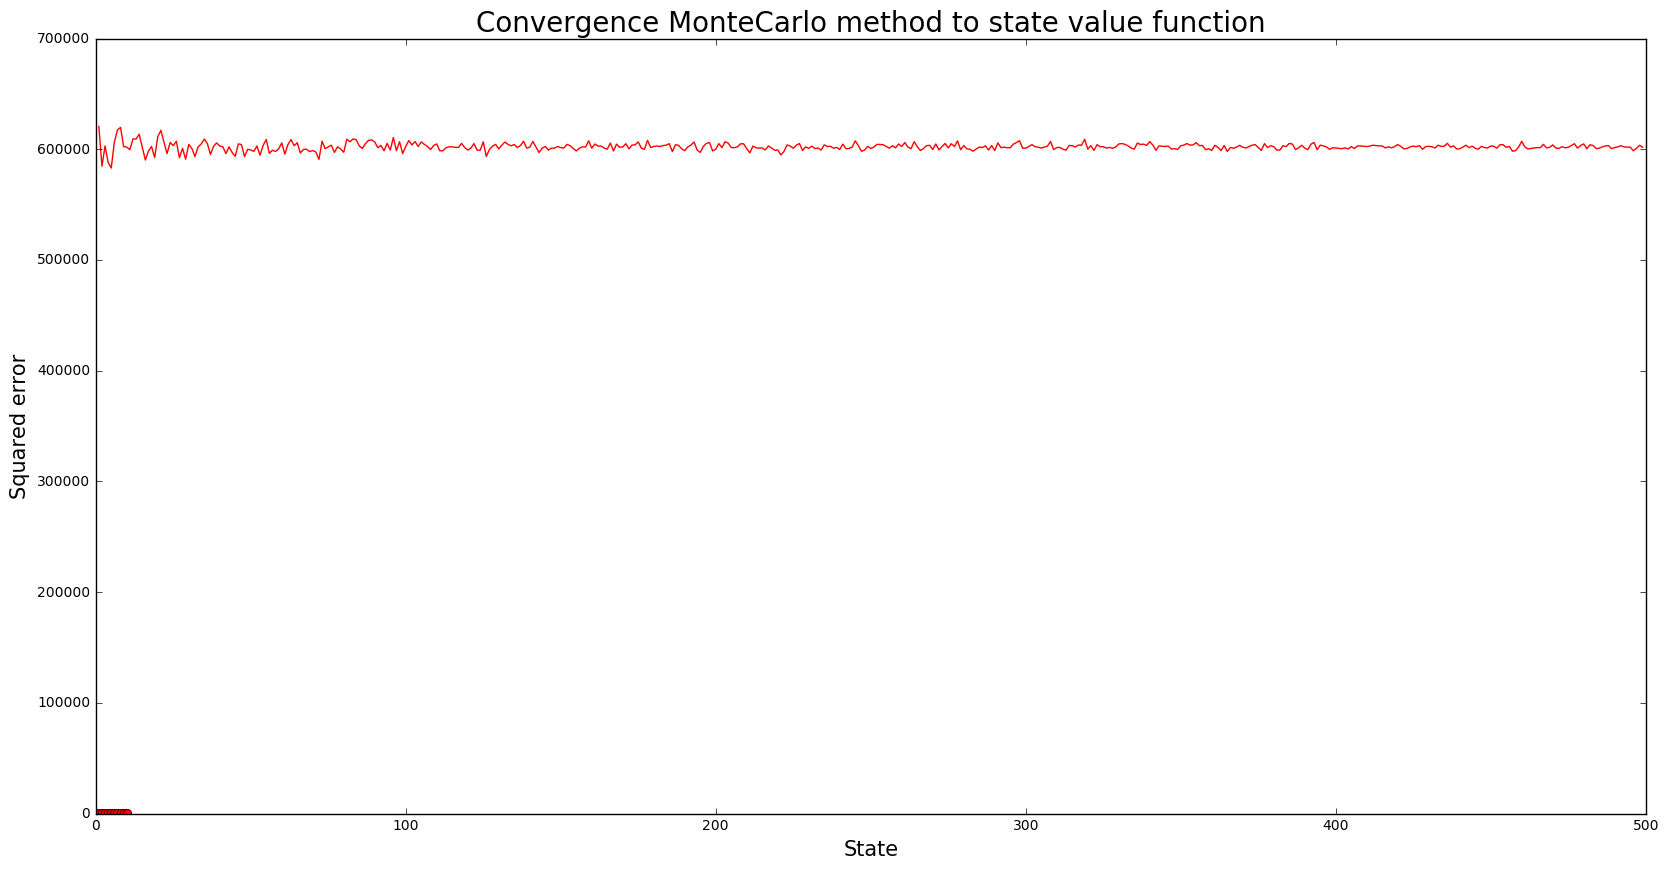

In [62]:
plt.figure(figsize=(20,10))
plt.plot(error,'r-')
plt.plot(Vmonte,'ro')
plt.title('Convergence MonteCarlo method to state value function',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('Squared error',fontsize=15)
plt.show()

Until a start from height 25 our three methods give more or less the same evaluation of our policy. Above iterative method is more optimistic than the others and we have a gap.

### Stupid Agent 

On fait un agent qui ne coupe jamais

In [20]:
class StupidAgent(Agent):
    
    def __init__(self,cut=10):
        Agent.__init__(self)
        self.cut=cut
     
    # Doit implémenter une policy déterministe
    def policy(self,x):
         return 0
        

### Illustration

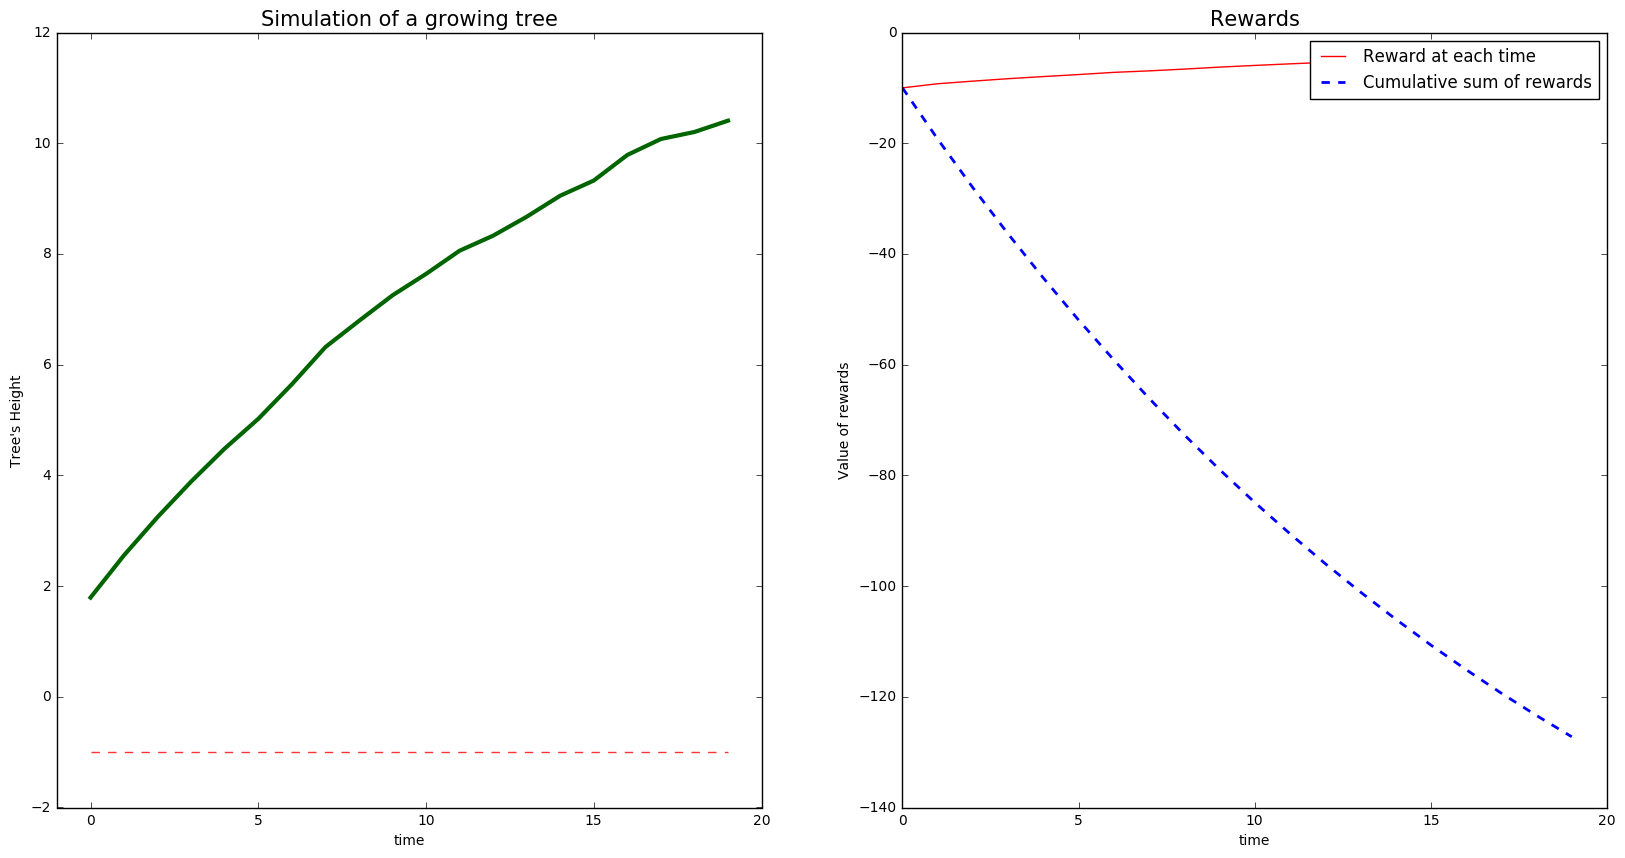

In [21]:
t=Tree(initSize=1,H=100)
stpA=StupidAgent()
stpA.plot_policy(nIter=20,nbRuns=1000,tree=t)

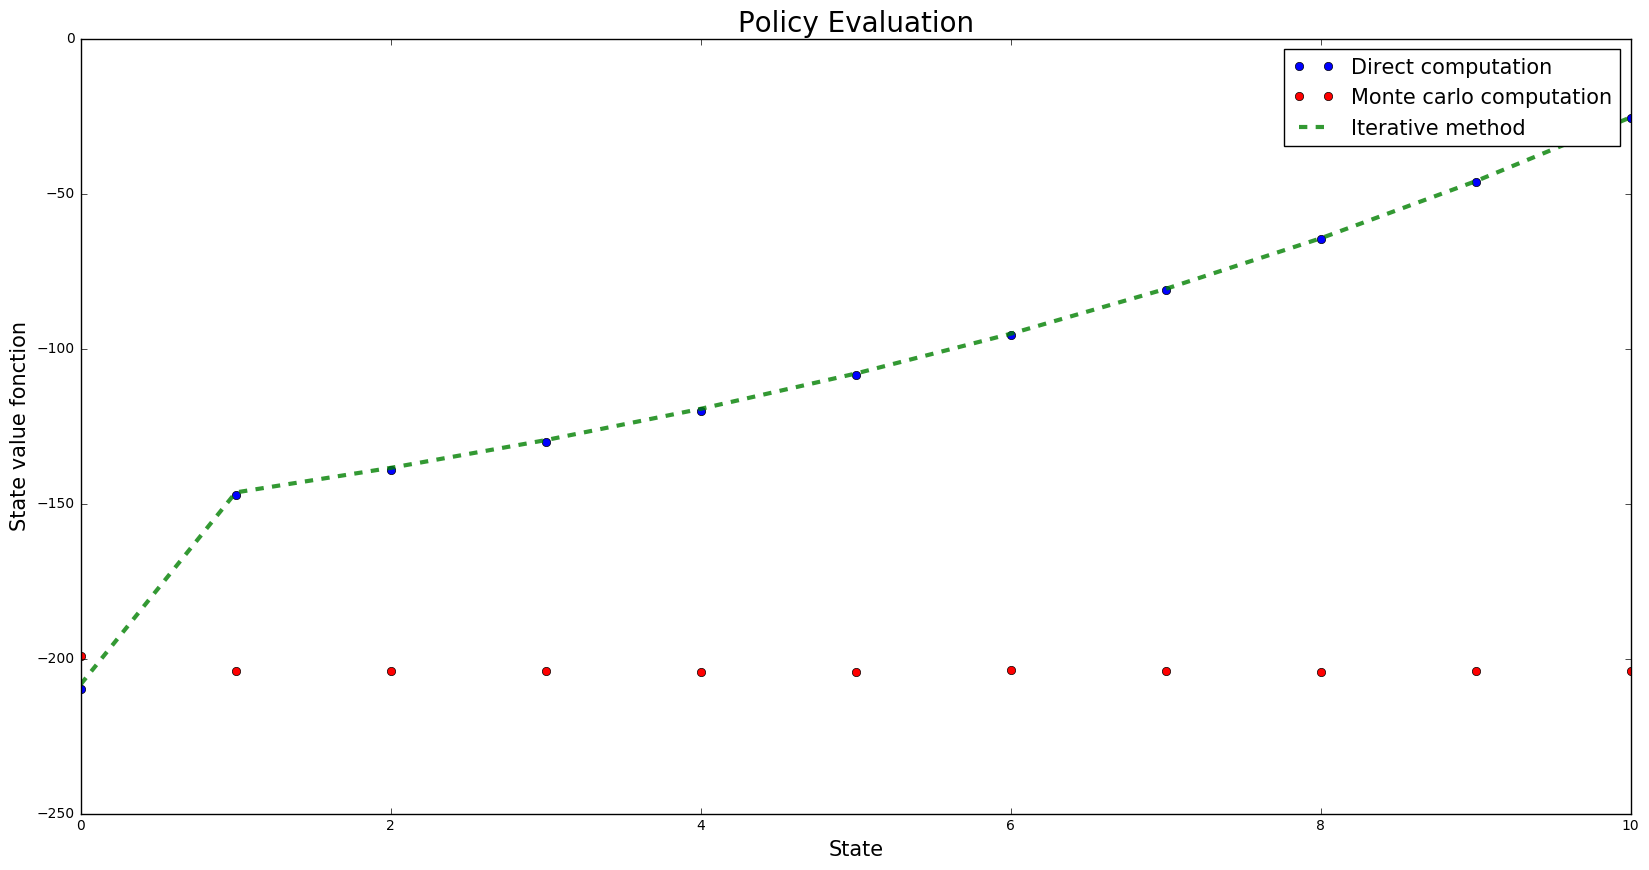

In [38]:
Vdirect=stpA.ev_policy_direct_computation(t)
Vmonte=stpA.ev_policy_motecarlo(t,200,300)
Vinte=stpA.ev_policy_iterative_computation(t,100)
plt.figure(figsize=(20,10))
plt.plot(Vdirect,'bo')
plt.plot(Vmonte,'ro')
plt.plot(Vinte,'g--',lw=3,alpha=0.8)
plt.title('Policy Evaluation',fontsize=20)
plt.xlabel('State',fontsize=15)
plt.ylabel('State value fonction',fontsize=15)
plt.legend(['Direct computation','Monte carlo computation','Iterative method'],fontsize=15)
plt.show()

Comme l'arbre tombre très rarement malade, et qu'être malade est la seule possibilité d'avoir un reward positif dans ce cas alors monte carlo doit merder mais je sais pas trop...